TODOS

1. convert mol dictionary to class variable [⋅]
2. add widgets and dynamicism/plots [⋅]
3. add more explanation/text describing functions [⋅]
4. add counter to avoid overwriting electronic structure input/output [⋅]
5. write README for tools folder on how to initiate jupyter notebook [X]
6. ask "why do jobs run until time limit? why don't they complete when finished?" [⋅]
7. add 2-dimensional plots [⋅]

<center><h2>Example 1: Calculate the potential energy surface </h2> </center> <br>
---
    
    
This notebook builds the potential energy surface (PES) of pairs of molecules along characteristic coordinates. N-dimensional scans can be performed and plotted to show the PES.<br>
<br>

 <i>Author</i>: <a href="https://github.com/oosode">Olaseni Sode</a> <br>
 <i>Created on</i>: June 1, 2018 <br>
 <i>Tags</i>: PES, electronic structure<br>

# Contents

---
   - [0. Load imports](#0.-Load-imports)
   - [1. Load data flow kernel](#1.-Load-data-flow-kernel)
   - [2. Choose molecules](#2.-Choose-molecules)
   - [3. Pick theory](#3.-Pick-theory)
   - [4. Optimize monomers](#4.-Optimize-monomers)
   - [5. Configure dimer](#5.-Configure-dimer)
   - [6. Optimize dimer](#6.-Optimize-dimer)
   - [7. Scan PES](#7.-Scan-PES)
   - [8. Plot PESs](#8.-Plot-PES)

## 0. Load imports

This cell imports the necessary modules. To execute a cell, click on it, then press <kbd>shift</kbd> + <kbd>enter</kbd>. (If you're new to the notebook environment, you may want to check out [this helpful cheat sheet](https://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb)).

In [301]:
import os
import sys
import gc


import ipywidgets as widgets
from subprocess import Popen, PIPE
from parsl import *
from math import *
from copy import *
from molecule import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cirpy

%matplotlib inline

#set plot sizes
plt.rcParams['figure.figsize'] = (10, 20)  # (width, height)
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 16

## 1. Load data flow kernel

In [6]:
from parsl.configs.local import localThreads

config = {
    "sites": [
        {
            "site": "midway_ipp_multicore",
            "auth": {
                "channel": "local",
                "hostname": "swift.rcc.uchicago.edu",
                "scriptDir": "/scratch/midway2/{0}/parsl_scripts".format('oosode')
            },
            "execution": {
                "executor": "ipp", # remote executor
                "provider": "slurm", 
                "block": {
                    "nodes": 1, # nodes per block
                    "taskBlocks": 1, # tasks per block
                    #"taskBlocks":20, 
                    "walltime": "00:05:00",
                    "initBlocks": 1,
                    "minBlocks" : 1,
                    "maxBlocks": 10,
                    "options": {'partition' : 'westmere',
                                'overrides' : 'source activate python36' }
                }
            }
        }, 
        {
            "site": "midway_ipp_singlenode",
            "auth": {
                "channel": "local",
                "hostname": "swift.rcc.uchicago.edu",
                "scriptDir": "/scratch/midway2/{0}/parsl_scripts".format('oosode')
            },
            "execution": {
                "executor": "ipp", # remote executor
                "provider": "slurm", 
                "block": {
                    "nodes": 1, # nodes per block
                    #"taskBlocks": 1, # tasks per block
                    "taskBlocks":20, 
                    "walltime": "00:15:00",
                    "initBlocks": 1,
                    "minBlocks" : 1,
                    "maxBlocks": 1,
                    "options": {'partition' : 'westmere',
                                'overrides' : 'source activate python36' }
                }
            }
        }
        
    ],
    "globals": {
        "lazyErrors": True,
    },
    #"controller" : {'publicIp' : ''}
}

#dfk = DataFlowKernel(config=config)
dfk = DataFlowKernel(config=localThreads)

### Function to write electronic structure input files

In [7]:
@App('bash', dfk, sites=['midway_ipp_singlenode'])
def write_input(ID,mol,theory,basis,program,optimization,f12,cp,outputs=[],stderr=None,stdout=None):
#def molpro(ID, outputs=[], stderr=None, stdout=None):
    
    natoms=int(mol.natoms)
    
    if program=="MOLPRO":
        
        fout=open("%s.%06d.com"%("molpro",ID),"w")
        fout.write("***, %s %s \n"%(mol.name,optimization))
        fout.write("memory,100,M\n")
        fout.write("geometry={\n")
        
        for i in range(natoms):

            fout.write("%s%d "%(mol.atom[i],i))
            fout.write("%15.10f, %15.10f, %15.10f"%(mol.coord[i][0],\
                                                    mol.coord[i][1],\
                                                    mol.coord[i][2]))
            if i==natoms-1:
                fout.write("}\n")
            else:
                fout.write("\n")

        fout.write("basis=%s"%(basis))
        fout.write("\n")

        if cp:
            fout.write("text,cp calculation for %s %dmer_%i\n"%(name,m,n))
            fout.write("dummy,")
            for i in range(atoms):
                if molid[i] in dum:
                    tmp=index*atoms
                    fout.write("%s%d,"%(names[tmp+i],i))
                    fout.write("\n")
                else:
                    fout.write("text,calculation for %s %dmer\n"%(name,m))

        if theory!="hf":
            fout.write("hf\n")
            fout.write("%s"%(theory))
            if f12:
                fout.write("-f12\n")
            else:
                fout.write("\n")
        else:
            fout.write("hf\n")
            
        if optimization=="Minimum":
            fout.write("optg\n")
            fout.write("maxit=50\n")
        if optimization=="Saddle":
            fout.write("optg")

        fout.write("e_mer=energy\n")
        if (f12):
            fout.write("e_mer_F12a=energy(1)\n")
            fout.write("e_mer_F12b=energy(2)\n")
        fout.write("\n")
        fout.close()
        return
        
    if program=="NWChem":
        pass
    

In [8]:
def write_input(ID,mol,theory,basis,program,optimization,f12,cp):
#def molpro(ID, outputs=[], stderr=None, stdout=None):
    
    natoms=int(mol.natoms)
    
    if program=="MOLPRO":
        
        fout=open("%s.%06d.com"%("molpro",ID),"w")
        fout.write("***, %s %s \n"%(mol.name,optimization))
        fout.write("memory,100,M\n")
        fout.write("geometry={\n")
        
        for i in range(natoms):

            fout.write("%s%d "%(mol.atom[i],i))
            fout.write("%15.10f, %15.10f, %15.10f"%(mol.coord[i][0],\
                                                    mol.coord[i][1],\
                                                    mol.coord[i][2]))
            if i==natoms-1:
                fout.write("}\n")
            else:
                fout.write("\n")

        fout.write("basis=%s"%(basis))
        fout.write("\n")

        if cp:
            #This functionality doesn't exist yet.
            pass
        #    fout.write("text,cp calculation for %s %dmer_%i\n"%(name,m,n))
        #    fout.write("dummy,")
        #    for i in range(atoms):
        #        if molid[i] in dum:
        #            tmp=index*atoms
        #            fout.write("%s%d,"%(names[tmp+i],i))
        #            fout.write("\n")
        #        else:
        #            fout.write("text,calculation for %s %dmer\n"%(name,m))

        if theory!="hf":
            fout.write("hf\n")
            fout.write("%s"%(theory))
            if f12:
                fout.write("-f12\n")
            else:
                fout.write("\n")
        else:
            fout.write("hf\n")
            
        if optimization=="Minimum":
            fout.write("optg\n")
            fout.write("maxit=50\n")
        if optimization=="Saddle":
            fout.write("optg")

        fout.write("e_mer=energy\n")
        if (f12):
            fout.write("e_mer_F12a=energy(1)\n")
            fout.write("e_mer_F12b=energy(2)\n")
        fout.write("\n")
        fout.close()
        return
        
    if program=="NWChem":
        pass

### Function to run electronic structure program

In [9]:
def run_input(ID,program):
    
    if program=="MOLPRO":
        process = Popen(["/Users/oosode/Software/molpro-2015/bin/molpro.exe", "molpro.%06d.com"%(ID)], stdout=PIPE)
        process.wait()
    elif program=="NWChem":
        process = Popen([],stdout=PIPE)
    else:
        raise IOError("Unknown program.") 
        
    return

In [5]:
#@App('bash', dfk, sites=['midway_ipp_singlenode'])
def molpro(ID, outputs=[], stderr=None, stdout=None):
    #return "uname -a; /home/oosode/software/molpro-2015/bin/molpro.exe  molpro.{0:06d}.com; touch molpro.{0:06d}.xml molpro.{0:06d}.out; sleep 15".format(ID)
    #return "uname -a; /home/oosode/software/molpro-2015/bin/molpro.exe  molpro.{0:06d}.com".format(ID)
    return "uname -a; /Users/oosode/Software/molpro-2015/bin/molpro.exe  molpro.{0:06d}.com".format(ID)

### Function to read electronic structure ouptut

In [36]:
@App('bash', dfk, sites=['midway_ipp_singlenode'])
def read_output(ID,program,mol,ouptuts=[],stderr=None,stdout=None):
    
    energy={}
    
    if program=="MOLPRO":    
        c=False
        fout="molpro.%06d.out"%(ID)
        if not os.path.isfile(fout):
            raiseIOError("No file for molpro.%06d.com"%(ID))

        else:
            fl=open(fout).readlines()

            for l in range(len(fl)-1,len(fl)-5,-1):
                if fl[l].find("Variable memory released")>=0:
                    c=True
                    break

            if (not c):
                energy['simple']="inf"
                mol['energy']=energy
                print("No energies for file molpro.%06d.com"%(ID))
                return

            else:
                for l,line in enumerate(fl):
                    if line.find("SETTING E_MER ")>=0: # energy
                        energy['simple']=float(line.strip().split()[-2].replace("D","E"))
                        mol['energy']=energy
                        
                    #if line.find("SETTING E_MER_F12A ")>=0: # F12a energy
                    #    energy['f12a']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    #elif line.find("SETTING E_MER_F12B ")>=0: # F12b energy
                    #    energy['f12b']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    
                    elif line.find("END OF GEOMETRY OPTIMIZATION.")>=0:
                        natoms=int(fl[l+4].split()[0])
                        for n in range(natoms):
                            for i in range(3):
                                mol['coord'][n][i]=float(fl[l+6+n].split()[i+1])
                    
            return



NameError: name 'dfk' is not defined

In [10]:

def read_output(ID,program,mol):
    
    energy={}
    
    if program=="MOLPRO": 
        
        c=False
        fout="molpro.%06d.out"%(ID)
        if not os.path.isfile(fout):
            raiseIOError("No file for molpro.%06d.com"%(ID))

        else:
            fl=open(fout).readlines()

            for l in range(len(fl)-1,len(fl)-5,-1):
                if fl[l].find("Variable memory released")>=0:
                    c=True
                    break

            if (not c):
                energy[0]="inf"
                print("No energies for file molpro.%06d.com"%(ID))
                return

            else:
                for l,line in enumerate(fl):
                    if line.find("SETTING E_MER ")>=0: # energy
                        #print("hello")
                        energy['simple']=float(line.strip().split()[-2].replace("D","E"))
                    
                        mol.energy=energy
                        #print(mol['energy'])
                        
                    #if line.find("SETTING E_MER_F12A ")>=0: # F12a energy
                    #    energy['f12a']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    #elif line.find("SETTING E_MER_F12B ")>=0: # F12b energy
                    #    energy['f12b']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    
                    elif line.find("END OF GEOMETRY OPTIMIZATION.")>=0:
                        natoms=int(fl[l+4].split()[0])
                        if natoms != mol.natoms:
                            print("There is a mismatch in the number of atoms")
                        for n in range(natoms):
                            for i in range(3):
                                mol.coord[n][i]=float(fl[l+6+n].split()[i+1])
                    
            return


## 2. Choose molecules

The cells below allows you to pick the two types of molecules for the PES scan. It uses the cirpy module to resolve the name of the molecules and then loads the xyz coordinates and atom names into the `molecule` class. This class then configures the remaining values including atomic mass, number of atoms, etc. 

**NOTE:** You can change the molecule types from the default "carbon dioxide" to any other molecule in the chemical information resolver database. Just change the name below.

In [255]:
#!/usr/bin/env python 

import math,os,sys
import cirpy
import element

class molecule:
    def __init__(self,name,nmols):
        print("Intialized new molecule class: %s"%(name))
        self.name = name
        self.nmols = nmols
        self.coord = []
        self.mass = []
        self.atom = []
        self.frag = []

        return

    def resolve(self):
        res=cirpy.resolve(self.name, 'xyz')
        print("Resolved chemical identification of %s"%(self.name))
        r=res.split("\n")
        self.natoms=int(r[0])
        self.frag=[0]*self.natoms

        for i,line in enumerate(r):
            if i<=1:
                continue
            elif i<self.natoms+2:
                tmp=[float(line.split()[1]),
                     float(line.split()[2]),
                     float(line.split()[3])]
                self.coord.append(tmp)
                self.atom.append(line.split()[0])
                self.mass.append(element.ELEMENTS[self.atom[-1]].mass)
            else:
                continue
        return
    
    def init_dimer(self,m1,m2):
        
        
        self.name=m1.name+"-"+m2.name
        self.nmols=2
        self.coord=deepcopy(m1.coord)+deepcopy(m2.coord)
        self.mass=deepcopy(m1.mass)+deepcopy(m2.mass)
        self.natoms=m1.natoms+m2.natoms
        self.atom=deepcopy(m1.atom)+deepcopy(m2.atom)
        self.frag=[0]*m1.natoms+[1]*m2.natoms

        return
        
    def calculate_com(self):
    
        if self.nmols==1:
            x=0.0
            y=0.0
            z=0.0

            totalmass=0.0

            for a,atom in enumerate(self.coord):

                x+=atom[0]*self.mass[a]
                y+=atom[1]*self.mass[a]
                z+=atom[2]*self.mass[a]
                totalmass+=self.mass[a]

            x=x/totalmass
            y=y/totalmass
            z=z/totalmass

            self.com=[x,y,z]

        elif self.nmols==2:

            x1=x2=0.0
            y1=y2=0.0
            z1=z2=0.0

            totalmass1=totalmass2=0.0

            for c,coord in enumerate(self.coord):

                if self.frag[c]==0:
                    x1+=coord[0]*self.mass[c]
                    y1+=coord[1]*self.mass[c]
                    z1+=coord[2]*self.mass[c]
                    totalmass1+=self.mass[c]
                elif self.frag[c]==1:
                    x2+=coord[0]*self.mass[c]
                    y2+=coord[1]*self.mass[c]
                    z2+=coord[2]*self.mass[c]
                    totalmass2+=self.mass[c]

            x1=x1/totalmass1
            y1=y1/totalmass1
            z1=z1/totalmass1
                   
            x2=x2/totalmass2
            y2=y2/totalmass2
            z2=z2/totalmass2

            self.com=[x1,y1,z1,x2,y2,z2]
                   
        return
   
    def calculate_vector(self):
        """Function to calculate normalized vector."""

        self.calculate_com()
        
        for l in range(3):
            x=self.com[3]-self.com[0]
            y=self.com[4]-self.com[1]
            z=self.com[5]-self.com[2]
            
        norm=sqrt(x*x + y*y + z*z)
        self.vector=[x/norm,y/norm,z/norm]
        self.radius=norm
        
        return

    
    def center(self):

        self.calculate_com()
        f=self.frag
                   
        for c,coord in enumerate(self.coord):
            coord[0]-=self.com[0+f[c]*3]
            coord[1]-=self.com[1+f[c]*3]
            coord[2]-=self.com[2+f[c]*3]         

        return

    def rotate_theta(self,theta,mID):

        if mID!=0 and self.nmols==1:
            print("This is a single molecule. The molecule ID should be zero.")  
            
        for c,coord in enumerate(self.coord):
            
            if self.frag[c]==mID:
                x=coord[0]
                y=coord[1]
                z=coord[2]

                r=sqrt(x*x + y*y + z*z)
                if r<1.0e-10:
                    continue
                    
                t=acos(z/r)
                p=atan2(y,x)
                t+=radians(theta)

                coord[0]=r*sin(t)*cos(p)
                coord[1]=r*sin(t)*sin(p)
                coord[2]=r*cos(t)

        return
    
    def rotate_phi(self,phi,mID):
        
        if mID!=0 and self.nmols==1:
            print("This is a single molecule. The molecule ID should be zero.")  
            
        for c,coord in enumerate(self.coord):
            
            if self.frag[c]==mID:
                x=coord[0]
                y=coord[1]
                z=coord[2]

                r=sqrt(x*x + y*y + z*z)
                if r<1.0e-10:
                    continue
                    
                t=acos(z/r)
                p=atan2(y,x)
                p+=radians(phi)

                coord[0]=r*sin(t)*cos(p)
                coord[1]=r*sin(t)*sin(p)
                coord[2]=r*cos(t)

        return        

    def position(self,R,theta,phi):
        
        if self.nmols==1:
            print("This is a single molecule. The `position_molecule` function is for dimers.")        

        x=R*sin(theta)*cos(phi)
        y=R*sin(theta)*sin(phi)
        z=R*cos(theta)

        for c,coord in enumerate(self.coord):
            
            if self.frag[c]==1:
                coord[0]+=x
                coord[1]+=y
                coord[2]+=z

        return    
    
    def setup_dimer(self):
        """This function that each monomer is initially at the origin, before
        transformation."""
        
        self.calculate_com()
        #self.R=0.0 # initial dimer distance
        #self.tv=[0.0]*3 # initial dimer vector
        self.center()
        return
        
    def transform_dimer(self,value,transform,mID):
        """This function prepares the dimer according to the type and magnitude 
        of transformation. Since translations shift the dimer off the origin, this
        operation is always perfomed last in the `set dimer` function."""
        
        if transform=="translation": # make translational vector
            self.radius=value
            
        elif transform=="phi" or transform=="theta": # rotate molecules
            
            for c,coord in enumerate(self.coord):
            
                if self.frag[c]==mID:
                    x=coord[0]
                    y=coord[1]
                    z=coord[2]

                    r=sqrt(x*x + y*y + z*z)
                    if r<1.0e-10:
                        continue

                    if transform=="phi":
                        p=atan2(y,x)
                        p+=radians(value)
                        
                        coord[0]=r*sin(0)*cos(p)
                        coord[1]=r*sin(0)*sin(p)
                        coord[2]=r*cos(0)
                        
                    elif transform=="theta":
                        p=atan2(y,x)
                        p+=radians(value)
                        
                        coord[0]=r*sin(0)*cos(p)
                        coord[1]=r*sin(0)*sin(p)
                        coord[2]=r*cos(0)
            
        else:
            raise IOError("Unknown transformation.")
            
        return
            
    def set_dimer(self):
        """"""
        
        for c,coord in enumerate(self.coord):
            if self.frag[c]==1:
                coord[0]+=self.vector[0]*self.radius
                coord[1]+=self.vector[1]*self.radius
                coord[2]+=self.vector[2]*self.radius
                
        return

if __name__=="__main__":
    pass


In [256]:

mol0 = molecule("CO2",1) # name and number of molecules
mol0.resolve()

mol1 = molecule("H2O",1)
mol1.resolve()

mList = (mol0,mol1)

Intialized new molecule class: CO2
Resolved chemical identification of CO2
Intialized new molecule class: H2O
Resolved chemical identification of H2O


## 3. Pick theory

The cells below allows you to choose the level of electronic structure theory, the basis set, the use of explicit correlation and the electronic structure program. (Currently, only the MOLPRO software package is implemented.) 

Some configurations of theory, basis set and programs are not possible. Once you have selected your program variables, make sure to check the configurations availability with the `wrapper.check()` function.


In [257]:
style = {'description_width': 'initial'}

theory=widgets.Dropdown(
       options=['HF', 'MP2', 'CCSD(T)'],
       value='HF',
       description='Theory:',
       disabled=False,
       visible=False
)

f12=widgets.RadioButtons(
    options=['True', 'False'],
    description='Explicit correlation:',
    disabled=False,
    style=style,
    visible=False
)
basis=widgets.Dropdown(
      options=['aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ',\
               'cc-pVDZ-F12', 'cc-pVTZ-F12', 'cc-pVQZ-F12'],
      value='aug-cc-pVDZ',
      description='Basis set:',
      disabled=False,
      visible=False
)
w=widgets.RadioButtons(
    options=['MOLPRO', 'NWChem'],
    description='Program:',
    disabled=False
)
display(w)
display(theory,f12,basis)

theory="hf"
basis="aug-cc-pVDZ"
f12=False
program="MOLPRO"

RadioButtons(description='Program:', options=('MOLPRO', 'NWChem'), value='MOLPRO')

Dropdown(description='Theory:', options=('HF', 'MP2', 'CCSD(T)'), value='HF')

RadioButtons(description='Explicit correlation:', options=('True', 'False'), style=DescriptionStyle(descriptio…

Dropdown(description='Basis set:', options=('aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ', 'cc-pVDZ-F12', 'cc-pV…

## 4. Optimize monomers

You can optimize the two monomers in the cells below. In the first cell, the input files are written. The second cell submits the input files and waits for them to finish. The last cell parses the output file and recovers the data. When running jobs on a compute cluster, the status of the job can be checked using the `qstat` command. The final energy and cartesian coordinates of the geometry are printed. 

**Write input files**:

In [258]:
for ID in range(2):
    #fut = write_input(ID,pair[ID],theory,basis,program,"Minimum",f12,False,outputs=["molpro.%06d.com"%(ID)])
    write_input(ID,mList[ID],theory,basis,program,"Minimum",f12,False)


**Run calculations**:

In [259]:
for ID in range(2):
    run_input(ID,program)
    #fut = molpro(ID, outputs=["molpro.%06d.out"%(ID), "molpro.%06d.xml"%(ID)],
    #             stdout="molpro.%06d.stdout"%(ID),
    #             stderr="molpro.%06d.stderr"%(ID))

**Check status**:

In [260]:
#!qstat -u $USER

**Read output**:

In [261]:
for ID in range(2):
    read_output(ID,program,mList[ID])

## 5. Configure dimers

Once the isolated monomers are obtained (and optimized), the next step is to orient them with respect to one another. This is done using a spherical coordinate space, shown below. The __orientation of molecule 1__ and the __orientation of molecule 2__ are determined first, followed by the __position__ of molecule 2 relative to molecule 1. 

Molecule 1 is always placed at the origin (0,0,0) oriented in space with $\theta_1$ and $\phi_1$. The range of $\theta_1$ is [0°, 180°] and the range of $\phi_1$ is [0, 360°). Molecule 2 is placed using spherical coordinates at some distance R from the origin, with $\theta_d$ and $\phi_d$ ranging from [0°, 180°] and [0, 360°), respectively. The orientation of Molecule 2 is denoted by $\theta_2$ and $\phi_2$ values. All angles are in degree units and distances are in angstroms.

<img src='https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Spherical.svg' style="width: 300px;">

#### Orientation of molecule 1

In [262]:
theta_0 = 0
phi_0 = 0

#### Orientation of molecule 2

In [263]:
# orient molecule 1
theta_1 = 180
phi_1 = 180

#### Position

In [264]:
# position
R = 4.0
theta_d = 0
phi_d = 0

In [265]:
tList = (theta_0,theta_1)
pList = (phi_0,phi_1)

#### Orient dimer

In [266]:
for i,m in enumerate(mList):
    m.calculate_com()
    m.center()
    m.rotate_theta(tList[i],0)
    m.rotate_phi(pList[i],0)


In [267]:
dimer=molecule("whatever",1)
dimer.init_dimer(mList[0],mList[1])
dimer.position(R,theta_d,phi_d)
dimer.calculate_vector()

Intialized new molecule class: whatever


## 6. Optimize dimer structure

The dimer structure can be optimized such that any potential energy scan originates from either a global or local minimum, or a saddle point. To optimize to a minimum, set the optimization flag to `Minimum`, and to optimize to a saddle point, set the optimization variable to `Saddle`. If you prefer not to optimize the dimer further, specify `None`.



In [268]:
optimization="None"

In [269]:
if optimization=="None":
    pass
elif optimization=="Minimum" or "Saddle":
    pass
    #write_input(3,dim,theory,basis,program,optimization,f12,False)
    #run_input(3,program)
    #read_output(3,program)
    
else:
    raise IOError("Unknown optimization.")

## 7. Setup scan

The potential energy surface will be scanned along some characteristic coordinate(s). There is no limit to the number coordinates to scan however, the maximum coupling between coordinates is 2. Some examples of coordinates include the 'R' distance, the $\phi_1$ angle or the $\theta_d$ angle. For each coordinate, the range of values and the increment must be specified. Increments for distances are in angstroms and are in degrees for angles. 

**Which variables?**

In [270]:
class Var:
    def __init__(self,name,minimum,maximum,inc,unit,mID=1):
        self.name=name
        self.min=minimum
        self.max=maximum
        self.inc=inc
        self.unit=unit
        self.molID=mID
        self.current=self.min
        return
        
    def determine_range(self):
        x=self.min
        tmp=[]
        while x<=self.max:
            tmp.append(x)
            x+=self.inc
        self.ranges=tuple(tmp)
        return
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.current > self.max:
            raise StopIteration
        else:
            self.current += self.inc
            return self.current - self.inc
        

In [287]:
variables=[]

Rname = 'translation'
Rmini = 2.0
Rmaxi = 8.0
Rincr = 0.1
Runit = 'angstrom'

var1=Var(Rname,Rmini,Rmaxi,Rincr,Runit,1)
var1.determine_range()
variables.append(var1)

tname = 'theta'
tmini = -90.0
tmaxi =  90.0
tincr =  10.0
tunit = 'degrees'
tID = 0

#var2=Var(tname,tmini,tmaxi,tincr,tunit,tID)
#variables.append(var2)

**n variable coupling?**

In [272]:
nCUP=1

In [273]:
def PES_scan(dim,variables,nCUP):
    
    # do pes scan
    sList = [] # list dimers to scan
    
    if nCUP==1:
        for m in range(len(variables)):
            
            var0=deepcopy(variables[m])
            
            for v0 in iter(deepcopy(var0)):
                
                tmp=deepcopy(dim) # copy dimer
                tmp.setup_dimer() 
                tmp.transform_dimer(v0,var0.name,var0.molID)
                tmp.set_dimer()
                sList.append(tmp)
                
    elif nCUP==2:
        for m in range(len(variables)):
            for n in range(m,len(variables)):
                
                var0=deepcopy(variables[m])
                var1=deepcopy(variables[n])
                
                for v0 in iter(var0):
                    for v1 in iter(var1):
                        
                        tmp=deepcopy(dim) # copy dimer
                        tmp.setup_dimer() 
                        tmp.transform_dimer(v0,var0.name,var0.molID)
                        tmp.transform_dimer(v1,var1.name,var1.molID)
                        tmp.set_dimer()
                        sList.append(tmp)
    
    else:
        print("The coupling between variables (ncup) must be set to either 0 or 1.")
                
    print(len(sList))      
    return sList

## 8. PES scan

You can optimize the two monomers in the cells below. In the first cell, the input files are written. The second cell submits the input files and waits for them to finish. The last cell parses the output file and recovers the data. When running jobs on a compute cluster, the status of the job can be checked using the `qstat` command. The final energy and cartesian coordinates of the geometry are printed. 

In [274]:
dimer_scans=PES_scan(dimer,variables,nCUP)

#fout=open("test.xyz","w")
#for i in range(len(dimer_scans)):
#    fout.write("%d\n%d\n"%(dimer_scans[i]['natoms'],i))
#    for j in range(dimer_scans[i]['natoms']):
#        fout.write("%2s "%(dimer_scans[i]['atom'][j]))
#        fout.write("%lf %lf %lf\n"%(dimer_scans[i]['coord'][j][0],\
#                                    dimer_scans[i]['coord'][j][1],\
#                                    dimer_scans[i]['coord'][j][2]))
#fout.close()


61


In [275]:
print(dimer_scans[1].coord)

[[-1.1418296019, 8.899802609288219e-17, 1.9081127735955607e-17], [1.1418296019, -5.083577062097098e-17, 1.9081127735955607e-17], [0.0, -5.083577062097098e-17, -5.083577062097098e-17], [-0.7532755405, 0.5047420411293878, 2.1], [0.7532755405000001, 0.5047420411293877, 2.1], [-9.68147759927038e-18, -0.06359609647061207, 2.1]]


In [278]:
for k,dscan in enumerate(dimer_scans): # loop over monomers
    write_input(k+2,dscan,theory,basis,program,"None",f12,False)

In [280]:
for k in range(len(dimer_scans)):
    run_input(k+2,program)
    #fut = molpro(ID, outputs=["molpro.%06d.out"%(ID), "molpro.%06d.xml"%(ID)],
    #             stdout="molpro.%06d.stdout"%(ID),
    #             stderr="molpro.%06d.stderr"%(ID))

In [ ]:
!qstat -u $USER

In [283]:
y=[]
for k,dscan in enumerate(dimer_scans): # loop over dimers
    read_output(k+2,program,dscan)
    y.append(dscan.energy['simple'])


[-263.66255194, -263.67664066, -263.68679126, -263.69398636, -263.69899959, -263.70242547, -263.70471206, -263.70619166, -263.70710788, -263.70763791, -263.70790935, -263.70801278, -263.708011, -263.70794632, -263.70784633, -263.7077285, -263.70760374, -263.70747882, -263.70735798, -263.70724393, -263.70713829, -263.70704194, -263.70695516, -263.70687775, -263.70680917, -263.70674866, -263.70669534, -263.70664829, -263.70660668, -263.70656972, -263.70653677, -263.70650729, -263.70648083, -263.70645703, -263.70643558, -263.70641625, -263.70639879, -263.70638301, -263.70636872, -263.70635575, -263.70634395, -263.70633318, -263.70632333, -263.70631428, -263.70630595, -263.70629826, -263.70629116, -263.70628459, -263.70627851, -263.70627289, -263.70626769, -263.70626289, -263.70625845, -263.70625436, -263.70625059, -263.70624712, -263.70624392, -263.70624099, -263.70623829, -263.70623581, -263.70623352]


## 9. Plot PES



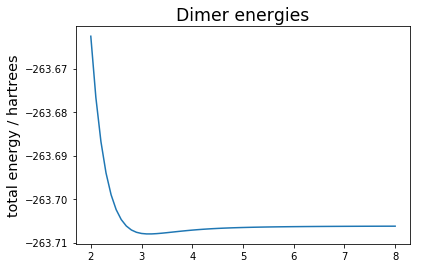

In [309]:
%matplotlib inline
plt.figure()
plt.title("Dimer energies", size='xx-large')
plt.ylabel("total energy / hartrees", size='x-large')
#plt.ylim([-376.7752,-376.772])
plt.plot(variables[0].ranges,y)

Test

<IPython.core.display.Javascript object>


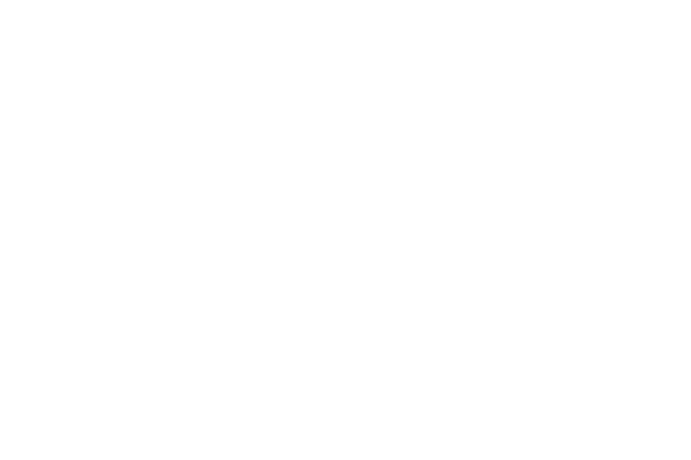

<IPython.core.display.Javascript object>


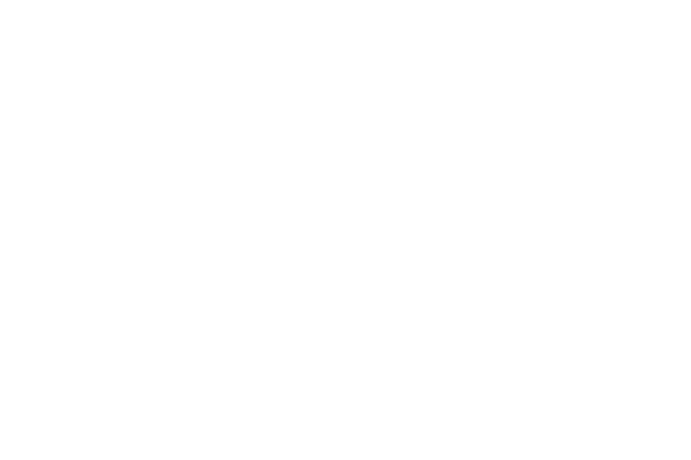

In [310]:
%matplotlib qt 
plt.figure()
plt.title("Dimer energies", size='xx-large')
plt.ylabel("total energy / hartrees", size='x-large')
plt.ylim([-376.7752,-376.772])
plt.plot(variables[0].ranges,y)
plt.show()